In [176]:
# ================================
#     INFLUENCER CREDIT SCORE
# ================================

# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------------
# SECTION 1: DATA LOADING
# --------------------------------


def load_data(file_path):
    """Load influencer data from CSV file."""
    try:
        df = pd.read_csv(file_path)
        print("Initial Data Loaded Successfully")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data('InfluencerData.csv')


# --------------------------------
# SECTION 2: DATA PREPROCESSING
# --------------------------------

def preprocess_data(df):
    """Preprocess the influencer dataset."""
    # Convert percentage strings to floats
    for col in ['Engagement Rate', '% Male Audience', '% Female Audience']:
        df[col] = df[col].str.rstrip('%').astype('float') / 100
    
    # Convert numerical columns to appropriate types
    df['Follower Count'] = df['Follower Count'].astype(int)
    df['Avg Video Views'] = df['Avg Video Views'].astype(int)

    # Handle 'Content Category'
    df['Content Category'] = df['Content Category'].astype(str).replace('nan', 'Unknown')
    df['Content Category'] = df['Content Category'].str.split(', ')
    df['Content Category'] = df['Content Category'].apply(lambda x: [x] if not isinstance(x, list) else x)
    mlb = MultiLabelBinarizer()
    categories = mlb.fit_transform(df['Content Category'])
    categories_df = pd.DataFrame(categories, columns=mlb.classes_, index=df.index)
    df = pd.concat([df, categories_df], axis=1)

    # Parse 'Top Audience Country' columns
    def parse_country(country_str):
        """Parse country and percentage from string."""
        if pd.isnull(country_str):
            return {'Country': None, 'Percentage': None}
        try:
            country, percentage = country_str.split(' (')
            percentage = percentage.rstrip('%)')
            return {'Country': country.strip(), 'Percentage': float(percentage)}
        except:
            return {'Country': country_str.strip(), 'Percentage': None}

    for i in range(1, 4):
        col = f'Top Audience Country {i}'
        parsed = df[col].apply(parse_country)
        df[f'Top Country {i}'] = parsed.apply(lambda x: x['Country'])
        df[f'Top Country {i} Percentage'] = parsed.apply(lambda x: x['Percentage'])

    df.drop(columns=[f'Top Audience Country {i}' for i in range(1, 4)], inplace=True)

    # Encode 'Creator Location'
    creator_location_dummies = pd.get_dummies(df['Creator Location'], prefix='Creator_Location')
    df = pd.concat([df, creator_location_dummies], axis=1)

    return df, mlb

df, mlb = preprocess_data(df)

# --------------------------------
# SECTION 3: FEATURE ENGINEERING
# --------------------------------

def feature_engineering(df):
    """Create additional features for modeling."""
    df['Engagement to Follower Ratio'] = df['Engagement Rate'] / df['Follower Count']
    
    # Handle missing values for 'Top Country' columns
    df[['Top Country 1', 'Top Country 2', 'Top Country 3']] = df[['Top Country 1', 'Top Country 2', 'Top Country 3']].fillna('Unknown')
    
    # Create dummy variables for 'Top Country' columns
    stacked_countries = df[['Top Country 1', 'Top Country 2', 'Top Country 3']].stack()
    top_countries_dummies = pd.get_dummies(stacked_countries)
    top_countries = top_countries_dummies.groupby(level=0).sum()
    df = pd.concat([df, top_countries], axis=1)
    
    return df

df = feature_engineering(df)

# --------------------------------
# SECTION 4: DATA PREPARATION FOR MODELING
# --------------------------------

def prepare_model_data(df, scaler=None):
    """Prepare the feature matrix and target vector for modeling."""
    numerical_features = ['Follower Count', 'Engagement Rate', 'Avg Video Views', 'Engagement to Follower Ratio']
    if scaler is None:
        scaler = MinMaxScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    else:
        df[numerical_features] = scaler.transform(df[numerical_features])
    
    weights = {'Follower Count': 0.25, 'Engagement Rate': 0.35, 'Avg Video Views': 0.2}
    df['Composite Score'] = (
        weights['Follower Count'] * df['Follower Count'] +
        weights['Engagement Rate'] * df['Engagement Rate'] +
        weights['Avg Video Views'] * df['Avg Video Views']
    )
    
    feature_list = numerical_features + list(df.columns[df.columns.str.startswith('Creator_Location')]) + list(top_countries.columns)
    X = df[feature_list]
    y = df['Composite Score']
    
    return X, y, feature_list, scaler

X, y, feature_list, scaler = prepare_model_data(df)

# Save scaler and feature list for future use
joblib.dump(scaler, 'scaler.pkl')
with open('feature_list.json', 'w') as f:
    json.dump(feature_list, f)

# --------------------------------
# SECTION 5: MODEL TRAINING
# --------------------------------

def train_model(X, y):
    """Train the Random Forest Regressor model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model, X_test, y_test

model, X_test, y_test = train_model(X, y)

# Save the trained model
joblib.dump(model, 'credit_score_model.pkl')
joblib.dump(mlb, 'mlb_content_category.pkl')

# --------------------------------
# SECTION 6: MODEL EVALUATION
# --------------------------------

def evaluate_model(model, X_test, y_test):
    """Evaluate the model performance on the test set."""
    y_pred = model.predict(X_test) * 100
    mae = mean_absolute_error(y_test * 100, y_pred)
    mse = mean_squared_error(y_test * 100, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test * 100, y_pred)
    print("\nModel Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R^2): {r2}")
    return mae, rmse, r2

evaluate_model(model, X_test, y_test)

# --------------------------------
# SECTION 7: PREDICTING CREDIT SCORES FOR ALL INFLUENCERS
# --------------------------------

def predict_all_scores(df, model):
    """Predict credit scores for all influencers in the dataset."""
    # Predict credit scores for the entire dataset
    df['Predicted Credit Score'] = model.predict(X) * 100
    # Calculate percentile-based credit scores
    df['Percentile Credit Score'] = df['Predicted Credit Score'].rank(pct=True) * 100
    # Sort by 'Predicted Credit Score' in ascending order
    df_sorted = df[['Name', 'Handle', 'Predicted Credit Score', 'Percentile Credit Score']].sort_values(by='Predicted Credit Score', ascending=True)
    return df_sorted

# Get sorted influencers by credit score
df_sorted = predict_all_scores(df, model)

# Display sorted influencers with their percentile-based credit scores
print("\nInfluencers with Percentile-based Credit Scores (Ascending Order):")
print(df_sorted)

# Save the sorted influencers to CSV (optional)
df_sorted.to_csv('influencers_credit_scores_sorted.csv', index=False)

# --------------------------------
# SECTION 8: DEFINE THE PREDICTION FUNCTION FOR NEW INFLUENCERS
# --------------------------------

def predict_credit_score(influencer_data, model, mlb, scaler, feature_list):
    """Predict the credit score for a single influencer."""
    influencer_df = pd.DataFrame([influencer_data])

    # Preprocessing
    influencer_df['Engagement Rate'] = influencer_df['Engagement Rate'].str.rstrip('%').astype('float') / 100
    influencer_df['% Male Audience'] = influencer_df['% Male Audience'].str.rstrip('%').astype('float') / 100
    influencer_df['% Female Audience'] = influencer_df['% Female Audience'].str.rstrip('%').astype('float') / 100
    
    influencer_df['Content Category'] = influencer_df['Content Category'].astype(str).replace('nan', 'Unknown')
    influencer_df['Content Category'] = influencer_df['Content Category'].str.split(', ')
    influencer_df['Content Category'] = influencer_df['Content Category'].apply(lambda x: [x] if not isinstance(x, list) else x)
    categories = mlb.transform(influencer_df['Content Category'])
    categories_df = pd.DataFrame(categories, columns=mlb.classes_, index=influencer_df.index)
    influencer_df = pd.concat([influencer_df, categories_df], axis=1)

    for i in range(1, 4):
        col = f'Top Audience Country {i}'
        influencer_df[col] = influencer_df[col].fillna('Unknown')
        parsed = influencer_df[col].apply(parse_country)
        influencer_df[f'Top Country {i}'] = parsed.apply(lambda x: x['Country'])
        influencer_df[f'Top Country {i} Percentage'] = parsed.apply(lambda x: x['Percentage'])

    top_countries = influencer_df[[f'Top Country {i}' for i in range(1, 4)]].stack()
    top_countries_dummies = pd.get_dummies(top_countries)
    top_countries_grouped = top_countries_dummies.groupby(level=0).sum()
    influencer_df = pd.concat([influencer_df, top_countries_grouped], axis=1)

    creator_location_dummies = pd.get_dummies(influencer_df['Creator Location'], prefix='Creator_Location')
    influencer_df = pd.concat([influencer_df, creator_location_dummies], axis=1)

    influencer_df['Engagement to Follower Ratio'] = influencer_df['Engagement Rate'] / influencer_df['Follower Count']
    
    numerical_features = ['Follower Count', 'Engagement Rate', 'Avg Video Views', 'Engagement to Follower Ratio']
    influencer_df[numerical_features] = scaler.transform(influencer_df[numerical_features])

    X_influencer = influencer_df.reindex(columns=feature_list, fill_value=0)
    predicted_score = model.predict(X_influencer)[0] * 100
    
    df['Predicted Credit Score'] = model.predict(X) * 100
    df['Percentile Credit Score'] = df['Predicted Credit Score'].rank(pct=True) * 100
    percentile_score = (predicted_score >= df['Predicted Credit Score']).mean() * 100

    return percentile_score

# --------------------------------
# SECTION 9: PREDICTING CREDIT SCORE FOR A NEW INFLUENCER
# --------------------------------

# Example influencer data
influencer_data = {
    'Name': 'John Doe',
    'Handle': '@johndoe',
    'Creator Location': 'United States of America',
    'Follower Count': 500000,
    'Engagement Rate': '2.5%',
    'Avg Video Views': 250000,
    '% Male Audience': '50%',
    '% Female Audience': '50%',
    'Top Audience Country 1': 'United States of America (95%)',
    'Top Audience Country 2': 'Canada (3%)',
    'Top Audience Country 3': 'United Kingdom (2%)',
    'Content Category': 'Fitness, Health',
    'Notes': ''
}

# Predict the credit score for the new influencer
credit_score = predict_credit_score(influencer_data, model, mlb, scaler, feature_list)
print(f"\nThe predicted credit score for {influencer_data['Name']} is: {credit_score}")

# --------------------------------
# SECTION 10: SAVE PREDICTED SCORES TO CSV
# --------------------------------

# Save the influencers with their percentile-based credit scores to a CSV file
df[['Name', 'Handle', 'Percentile Credit Score']].to_csv('influencers_credit_scores.csv', index=False)


Initial Data Loaded Successfully
                           Name              Handle          Creator Location  \
0         Siempre 💖 San Antonio  siempre_sanantonio  United States of America   
1           SAN ANTONIO | TEXAS    sanantoniofoodie  United States of America   
2  Melanie Demi | herboozytails       herboozytails  United States of America   
3               Hosting with Em       hostingwithem  United States of America   
4                  TEXAS TRAVEL      texas_explorer  United States of America   

   Follower Count Engagement Rate  Avg Video Views % Male Audience  \
0          128160           7.57%             8113          24.63%   
1          585941           7.57%            79277          29.67%   
2          809020           7.57%           166504          23.55%   
3           53883           7.57%           353091          27.79%   
4         1215818           7.57%           266519          32.68%   

  % Female Audience             Top Audience Country 1  \
0

/Users/nick/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nick/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nick/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nick/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nick/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **

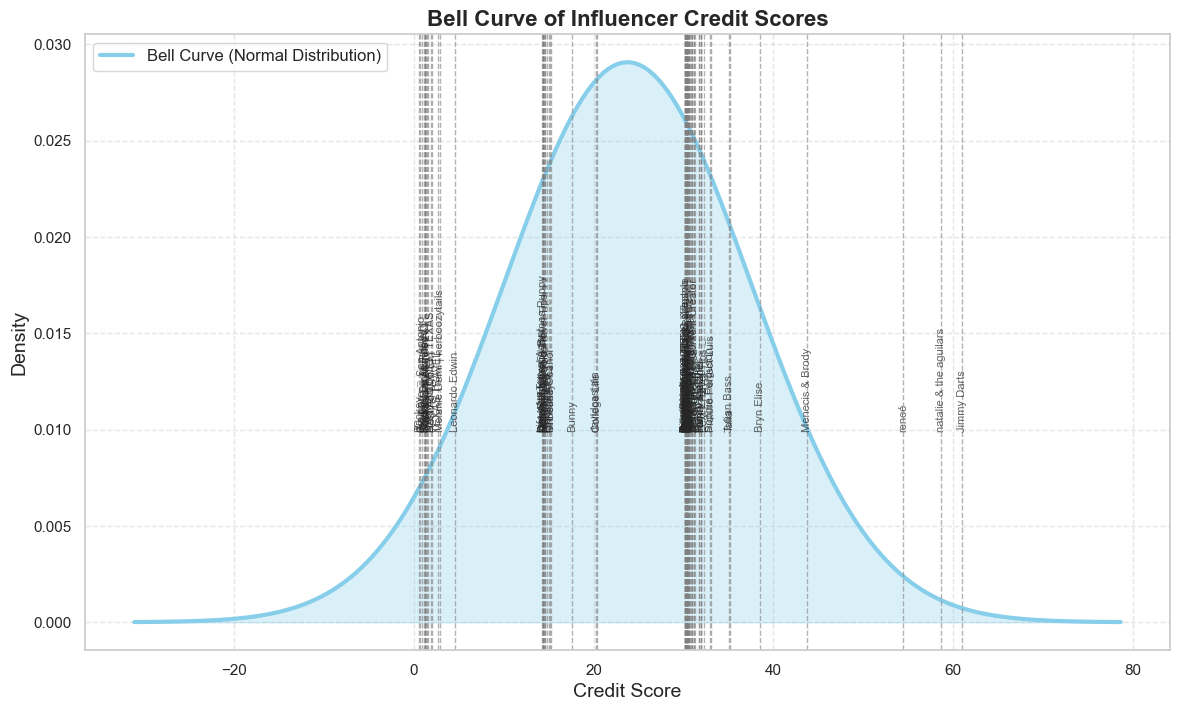

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `df` has the credit scores in a column named 'Predicted Credit Score'

# Calculate mean and standard deviation of the credit scores
mean_score = df['Predicted Credit Score'].mean()
std_score = df['Predicted Credit Score'].std()

# Create a range of credit scores around the mean for the bell curve
x = np.linspace(mean_score - 4*std_score, mean_score + 4*std_score, 1000)
y = (1 / (std_score * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_score) / std_score) ** 2)

# Plotting the bell curve
plt.figure(figsize=(14, 8))
plt.plot(x, y, color='skyblue', linewidth=3, label='Bell Curve (Normal Distribution)')
plt.fill_between(x, y, color='skyblue', alpha=0.3)

# Plot vertical lines and text for each influencer score
for index, row in df.iterrows():
    plt.axvline(row['Predicted Credit Score'], color='grey', linestyle='--', linewidth=1, alpha=0.6)
    plt.text(row['Predicted Credit Score'], 0.01, row['Name'], rotation=90, fontsize=8, alpha=0.7, ha='center')

# Add titles and labels
plt.title('Bell Curve of Influencer Credit Scores', fontsize=16, weight='bold')
plt.xlabel('Credit Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Show the plot
plt.show()
